# Exp7: Sentence Embeddings
This file tests neural networks trained on sentence embeddings to predict the presence of grammatical constructions in them.

In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score
import random
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))
import config

torch.manual_seed(config.SEED)
np.random.seed(config.SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Load dataset

In [30]:
df = pd.read_json('../dat/egpaugmented_6x1000.json')

Load and test embeddings model

In [31]:
embeddings_model = SentenceTransformer('llmrails/ember-v1')

# test model on the first sentence
sentences = [df['augmented_examples'].iloc[0][0]]
embeddings = embeddings_model.encode(sentences)

input_dim = embeddings.shape[1]  # Size of the sentence embeddings
print(input_dim)

1024


In [32]:
# Extracting one construct with its examples
row = df.iloc[0]
print(row['Can-do statement'])
print(row['Example'])
print("\n")
for element in row['augmented_examples'][:10]:
    print(element)
print("\n")
for element in row['augmented_negative_examples'][:10]:
    print(element)

class SentenceDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = embeddings
        self.labels = labels

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        return torch.tensor(self.embeddings[idx], device=device), torch.tensor(self.labels[idx], device=device)
    
def get_dataset(row, random_negatives=True):
    # assemble dataset for one construction
    # 50% positive examples
    sentences = list(row['augmented_examples'])
    labels = [1] * len(row['augmented_examples'])

    if random_negatives:
        ratio = 0.75
        num_rands = int(len(sentences) * ratio)
        num_augs = int(len(sentences) * (1-ratio))

        # 25% random negative examples (positive from other constructions)
        neg_examples = [example for sublist in df.loc[df['#'] != row['#'], 'augmented_examples'].to_list() for example in sublist]
        random.shuffle(neg_examples)
        sentences += neg_examples[:num_rands]
        labels += [0] * len(neg_examples[:num_rands])

        # 25% augmented negative examples
        aug_neg_examples = row['augmented_negative_examples']
        random.shuffle(aug_neg_examples)
        sentences += aug_neg_examples[:num_augs]
        labels += [0] * len(aug_neg_examples[:num_augs])
    else:
        sentences += row['augmented_negative_examples']
        labels = [0] * len(row['augmented_negative_examples'])

    embeddings = embeddings_model.encode(sentences)
    return SentenceDataset(embeddings, labels)

dataset = get_dataset(row)

Can use nouns and noun phrases as complements of the verb 'be'. 
There is a big garden. 

Hi Rie, It's Mohamad. 

He is a student in B6 College.


She is a doctor.
They are friends.
It was a mistake.
My sister is a teacher.
The book is written in English.
We are classmates.
The food is delicious.
This is my house.
The movie was amazing.
The cat is sleeping.


There exists a big garden.
Hi Rie, it actually is Mohamad.
He actually exists as a student in B6 College.
She happens to be a doctor.
They currently exist as friends.
It previously happened that it was a mistake.
My sister actually exists as a teacher.
The book actually exists, and it is written in English.
We currently exist as classmates.
The food actually happens to be delicious.


Create a data loader.

In [33]:
# Total size of the dataset
total_size = len(dataset)

# Specify the size of the training and validation sets
train_size = int(0.8 * total_size)  # 80% for training
val_size = total_size - train_size  # Remaining 20% for validation

# Split the dataset
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders for training and validation
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)


Let's define our network, a simple two layer Feed Forward Neural Network with a sigmoidal activation function.

In [34]:
class FeedforwardNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(FeedforwardNN, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(hidden_dim, 1)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        hidden = self.relu(self.fc1(x))
        output = self.sigmoid(self.fc2(hidden))
        return output

hidden_dim = 32
model = FeedforwardNN(input_dim, hidden_dim).to(device)

In [35]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total Parameters: {total_params}")
print(f"Trainable Parameters: {trainable_params}")

Total Parameters: 32833
Trainable Parameters: 32833


Now we can train the network with the sentence embeddings.

Early stopping at epoch 71


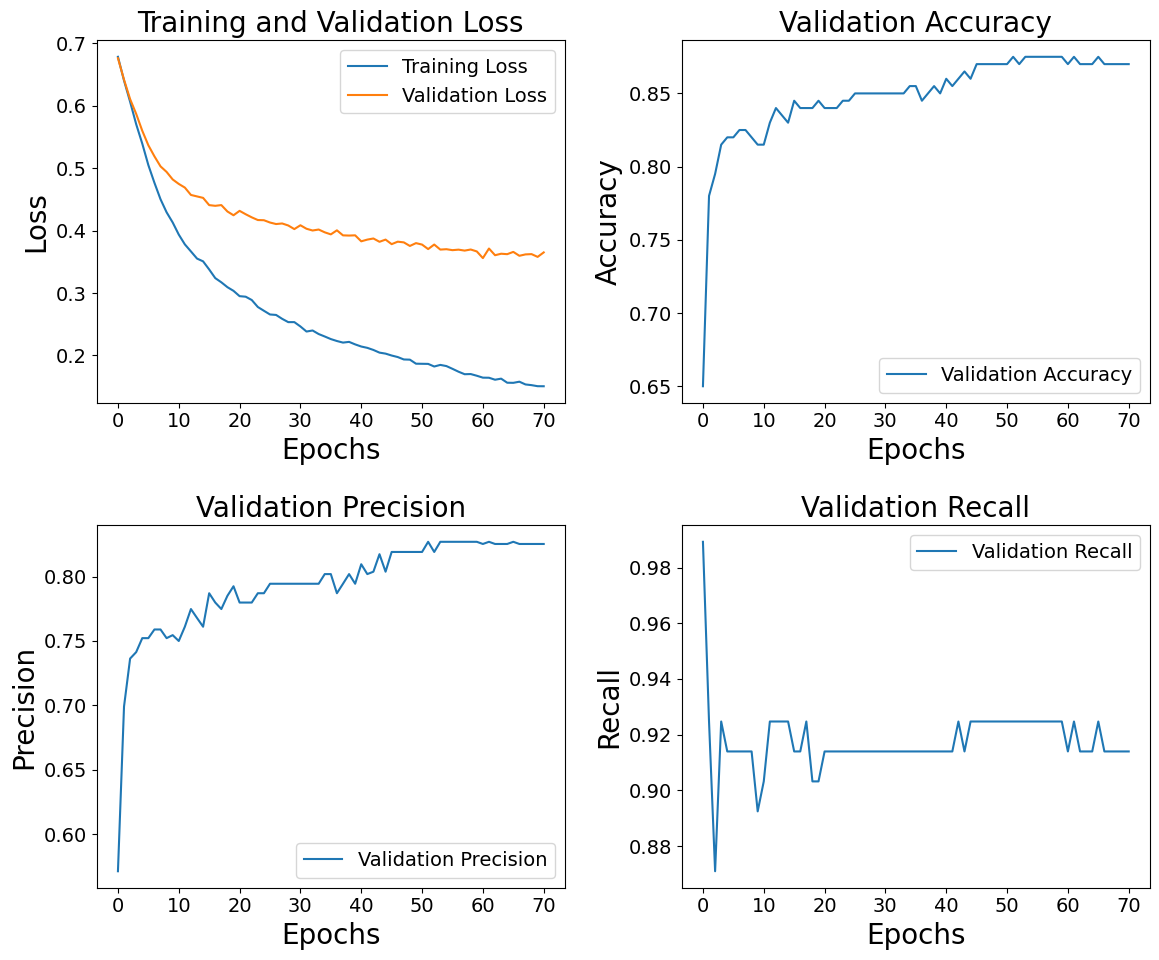

(FeedforwardNN(
   (fc1): Linear(in_features=1024, out_features=32, bias=True)
   (relu): ReLU()
   (fc2): Linear(in_features=32, out_features=1, bias=True)
   (sigmoid): Sigmoid()
 ),
 0.87,
 0.8252427184466019,
 0.9139784946236559)

In [36]:
# Loss and Optimizer
criterion = torch.nn.BCELoss()

def train(model, train_dataloader, val_dataloader, verbose=False, plots=True, n_epochs_stop = 10, lr=0.0001, num_epochs=200):
    optimizer = torch.optim.Adam(model.parameters(), lr)

    # Lists to store loss and accuracy values
    train_losses = []
    val_losses = []
    val_accuracies = []
    val_precisions = []
    val_recalls = []

    # Early stopping variables
    best_val_loss = float('inf')
    epochs_no_improve = 0

    # Training Loop
    for epoch in range(num_epochs):  # Number of epochs
        model.train()  # Set the model to training mode
        total_loss = 0
        train_steps = 0
        for inputs, targets in train_dataloader:
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets.float())

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            train_steps += 1
        
        avg_train_loss = total_loss / train_steps
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()  # Set the model to evaluation mode
        val_loss = 0
        val_steps = 0
        correct = 0
        total = 0
        all_targets = []
        all_predictions = []
        with torch.no_grad():
            for inputs, targets in val_dataloader:
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), targets.float())
                val_loss += loss.item()
                val_steps += 1

                predicted = outputs.round().squeeze()  # Assuming a binary classification

                # Accumulate all targets and predictions
                all_targets.extend(targets.tolist())
                all_predictions.extend(predicted.tolist())

                correct += (predicted == targets).sum().item()
                total += targets.size(0)

        # Calculating validation metrics
        avg_val_loss = val_loss / val_steps
        val_losses.append(avg_val_loss)
        val_accuracy = correct / total
        val_accuracies.append(val_accuracy)

        # Calculate precision and recall
        precision = precision_score(all_targets, all_predictions)
        recall = recall_score(all_targets, all_predictions)
        val_precisions.append(precision)
        val_recalls.append(recall)

        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve == n_epochs_stop:
                print(f'Early stopping at epoch {epoch+1}')
                break

        if verbose:
            print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, '
                f'Validation Accuracy: {val_accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')

    # Plotting training and validation loss, accuracy, precision, and recall
    if plots:
        plt.figure(figsize=(12, 10))

        plt.subplot(2, 2, 1)
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()

        plt.subplot(2, 2, 2)
        plt.plot(val_accuracies, label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Validation Accuracy')
        plt.legend()

        plt.subplot(2, 2, 3)
        plt.plot(val_precisions, label='Validation Precision')
        plt.xlabel('Epochs')
        plt.ylabel('Precision')
        plt.title('Validation Precision')
        plt.legend()

        plt.subplot(2, 2, 4)
        plt.plot(val_recalls, label='Validation Recall')
        plt.xlabel('Epochs')
        plt.ylabel('Recall')
        plt.title('Validation Recall')
        plt.legend()

        plt.tight_layout()
        plt.show()

    return model, val_accuracy, precision, recall

train(model, train_dataloader, val_dataloader, verbose=False)

Let's try cross validation to make sure that the validation is not influenced by the validation set sampling.

In [38]:
def CV_train(construction, k_folds = 5, batch_size=64, hidden_dim=32, random_negatives=True):
    print(construction['Can-do statement'])
    dataset = get_dataset(construction, random_negatives)

    accuracies = []
    precisions = []
    recalls = []

    kfold = KFold(n_splits=k_folds, shuffle=True)
    for fold, (train_ids, test_ids) in enumerate(kfold.split(list(range(len(dataset))))):
        print(f'FOLD {fold}')

        # Prepare data for fold
        trainloader = DataLoader(dataset, batch_size=batch_size, sampler=SubsetRandomSampler(train_ids))
        testloader = DataLoader(dataset, batch_size=batch_size, sampler=SubsetRandomSampler(test_ids))

        # Reinitialize model
        model = FeedforwardNN(input_dim, hidden_dim).to(device)

        # Train model
        model, val_accuracy, precision, recall = train(model, trainloader, testloader, plots=False)

        # Store metrics
        accuracies.append(val_accuracy)
        precisions.append(precision)
        recalls.append(recall)

    return accuracies, precisions, recalls

results = []
for idx, construction in df.iterrows():
    accuracies, precisions, recalls = CV_train(construction)
    print(accuracies)
    results.append({'Construction': construction['Level'] + '-' + str(construction['#']), 
                    'Accuracies': accuracies, 
                    'Precisions': precisions, 
                    'Recalls': recalls})
results_df = pd.DataFrame(results)

Can use nouns and noun phrases as complements of the verb 'be'. 
FOLD 0
Early stopping at epoch 84
FOLD 1
Early stopping at epoch 39
FOLD 2
Early stopping at epoch 65
FOLD 3
Early stopping at epoch 78
FOLD 4
Early stopping at epoch 46
[0.905, 0.875, 0.905, 0.905, 0.895]
Can use prepositional phrases in the front position for focus.
FOLD 0
Early stopping at epoch 32
FOLD 1
Early stopping at epoch 31
FOLD 2
Early stopping at epoch 56
FOLD 3
Early stopping at epoch 52
FOLD 4
Early stopping at epoch 47
[0.765, 0.73, 0.805, 0.8, 0.8]
Can form conditional subordinate clauses with 'if' + past simple, and would in the main clause, to talk about an imagined situation, often in the context of advice or opinion-giving. 
FOLD 0
Early stopping at epoch 70
FOLD 1
Early stopping at epoch 82
FOLD 2
Early stopping at epoch 70
FOLD 3
Early stopping at epoch 60
FOLD 4
Early stopping at epoch 34
[0.935, 0.95, 0.92, 0.945, 0.93]
Can use the past perfect continuous in a relative clause to give background in

In [17]:
results_df.to_json('../dat/classification_results_neg_ratio.json')

## Analyze results

In [21]:
results_df = pd.read_json('../dat/classification_results_neg_ratio.json')

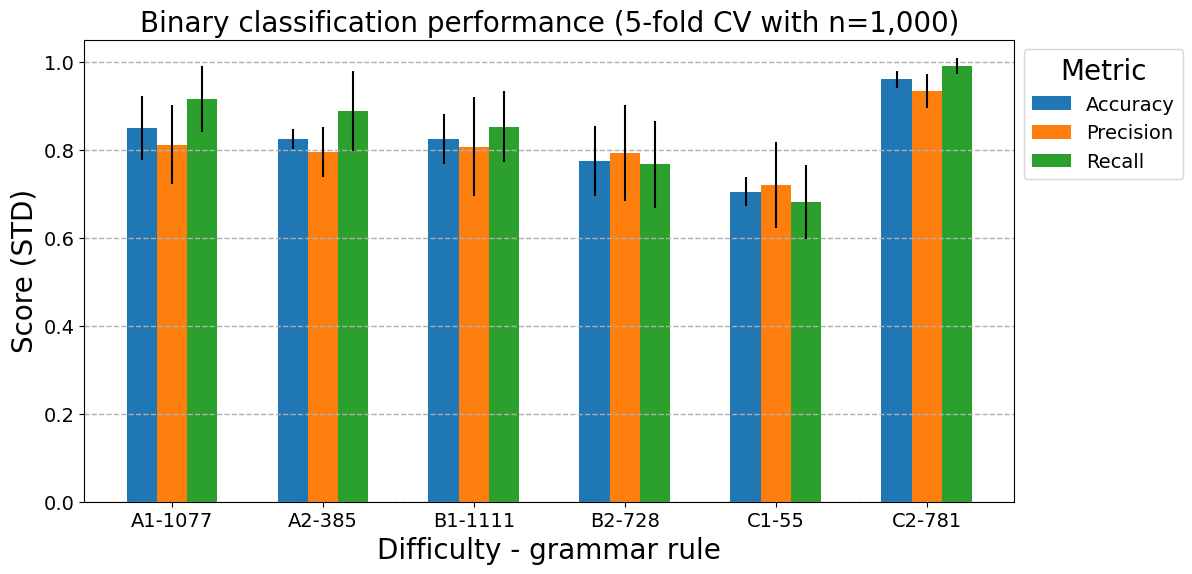

In [22]:
from matplotlib import rcParams

# Update default font sizes
rcParams.update({'font.size': 20, 'axes.labelsize': 20, 'axes.titlesize': 20, 'xtick.labelsize': 14,
                 'ytick.labelsize': 14, 'legend.fontsize': 14})

def calculate_mean_std(values):
    return np.mean(values), np.std(values)

metrics = ['Accuracies', 'Precisions', 'Recalls']
for metric in metrics:
    results_df[[f'{metric} Mean', f'{metric} Std']] = results_df[metric].apply(calculate_mean_std).apply(pd.Series)

fig, ax = plt.subplots(figsize=(12, 6))
ax.set_ylim(0, 1.05)
width = 0.2
x = np.arange(len(results_df))

center_offset = width * (len(metrics) - 1) / 2
labels = ['Accuracy', 'Precision', 'Recall']
for i, metric in enumerate(metrics):
    ax.bar(x + i*width - center_offset, results_df[f'{metric} Mean'], width, yerr=results_df[f'{metric} Std'], label=labels[i])

ax.set_xlabel('Difficulty - grammar rule')
ax.set_ylabel('Score (STD)')
ax.set_title('Binary classification performance (5-fold CV with n=1,000)')
ax.set_xticks(x)
ax.set_xticklabels(results_df['Construction'])
#ax.legend()
plt.grid(True, which='major', axis='y', linestyle='--', linewidth=1)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Metric")


plt.savefig('../doc/classification.pdf', transparent=True, bbox_inches='tight')

Now let's train the models and save them to make them accessible:

In [12]:
batch_size=64
num_epochs=60
hidden_dim=32
random_negatives=True
lr=0.0001

for idx, construction in df.iterrows():
    print(construction['Can-do statement'])
    dataset = get_dataset(construction, random_negatives)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    model = FeedforwardNN(input_dim, hidden_dim).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        train_steps = 0
        for inputs, targets in loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets.float())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            train_steps += 1
    
    torch.save(model, f"../models/{construction['#']}.pth")

Can use nouns and noun phrases as complements of the verb 'be'. 
Can use prepositional phrases in the front position for focus.
Can form conditional subordinate clauses with 'if' + past simple, and would in the main clause, to talk about an imagined situation, often in the context of advice or opinion-giving. 
Can use the past perfect continuous in a relative clause to give background information.  ► relative clauses
Can use 'anything' with post-modifiers to form complex noun phrases as subjects with a singular verb, to give focus. 
Can use an increasing range of adjectives before a noun to express intensity.
